- Todo persist data locally for security
  
# Exercise 1: Life Expectancy
In this Step, you will create an animated scatterplot on global demography similar to the one in a famous talk by [Hans Rosling](https://www.youtube.com/watch?v=jbkSRLYSojo).

### Step 1: Download the Data
You will use data by the [Gapminder Foundation](https://www.gapminder.org). Go to www.gapminder.org/data and download CSV files on:
- life expectancy
- fertility rate, total
- population

### Step 2: Combine Data
Hint use `merge` with merge keys `country` and  `time`.

### Step: rename columns


### Step 3
Choose gdp and life expectancy for the year 2015 and put them into a single table.

### Step 4
Check if there a missing values. If so, Remove all rows with missing values.

### Step 5
Draw a scatterplot of gdp over life expectancy in 2015.

### Step 
Which overall trend do you observe
Inspect extreme cases
- Which countries have the highest / lowest life expectancy?
- Which countries have the highest / lowest gdp?

### Step 6
Repeat steps 3-5 for the year 1960. What differences do you observe?
Remark: if you look at plots take care of scales.

### Step 7
Write a function that allows you to draw a scatterplot for any given year.

# Bonus Exercise 2 Animation
Connect the scatterplots to an animation. Hint use matplotlib's FuncAnimation: `from matplotlib.animation import FuncAnimation`

# Exercise 2
- Look at the same by continent
    - -> need groupby.
# Bonus Exercise 3
look at data retrieval process. 
    - How did we 'hack' the csv download
    -> Motivates APIs

# Solutions Exercise 1

In [2]:
import pandas as pd
import requests
from matplotlib import pyplot as plt
import numpy as np

url_life_expectancy = 'https://small-waffle.gapminder.org/fasttrack/master/b2642a8?_select_key@=country&=time;&value@=lex;;&from=datapoints&where_'
url_gdp = 'https://small-waffle.gapminder.org/fasttrack/master/b2642a8?_select_key@=country&=time;&value@=gdp/_pcap;;&from=datapoints&where_'
url_population = 'https://small-waffle.gapminder.org/fasttrack/master/b2642a8?_select_key@=country&=time;&value@=pop;;&from=datapoints&where_'

def read_url(url):
    data = requests.get(url).json()
    return pd.DataFrame(data['rows'], columns=data['header'])

def retrieve_country_information():
    response = requests.get('https://restcountries.com/v3.1/all')
    cs = pd.DataFrame(response.json())[['name', 'cca3', 'region']]
    country = cs.name.map(lambda x: x['common'])
    cs = cs.assign(country=country)
    cs = cs.drop(columns='name')
    cs = cs.rename(columns={'cca3': 'country_short'})
    cs = cs.assign(country_short = cs.country_short.str.lower())
    return cs

In [3]:
df_life_expectancy = read_url(url_life_expectancy)
df_gdp = read_url(url_gdp)
df_population = read_url(url_population)
df_countries = retrieve_country_information()

In [4]:
keys = ['country', 'time']
df = (df_life_expectancy
      .merge(df_gdp, on=keys)
      .merge(df_population, on=keys)
      .rename(columns={'country': 'country_short'})
      .merge(df_countries, on='country_short', how='left')
     )


In [33]:
def rename(df): 
    columns = {'pop': 'population', 
               'gdp_pcap': 'gdp', 
               'lex': 'life_expectancy', 
               'country': 'country_short', 
                'time': 'year'}
    return df.rename(columns=columns) 
    
def filter_year(df, year):
    return df[df['year'] == year]

continent_colors = {'Asia': 'red', 
                    'Europe': 'pink', 
                    'Africa': 'blue', 
                    'Americas': 'yellow', 
                    'Oceania': 'brown'}

def scatter_plot(df):
    fix, ax = plt.subplots(figsize=(16, 10))
    sizes = np.sqrt(df.population) /10
    colors = df['region'].map(continent_colors)
    ax.scatter(df.gdp, df.life_expectancy, 
               s=sizes, 
               c=colors, 
               alpha=0.6, 
               edgecolors="w", 
               linewidth=2)
    ax.set_xlabel('GDP', fontsize=15)
    ax.set_ylabel('Life Expectancy', fontsize=15)
    ax.set_xlim(0, 100000)
    ax.set_ylim(25,90)

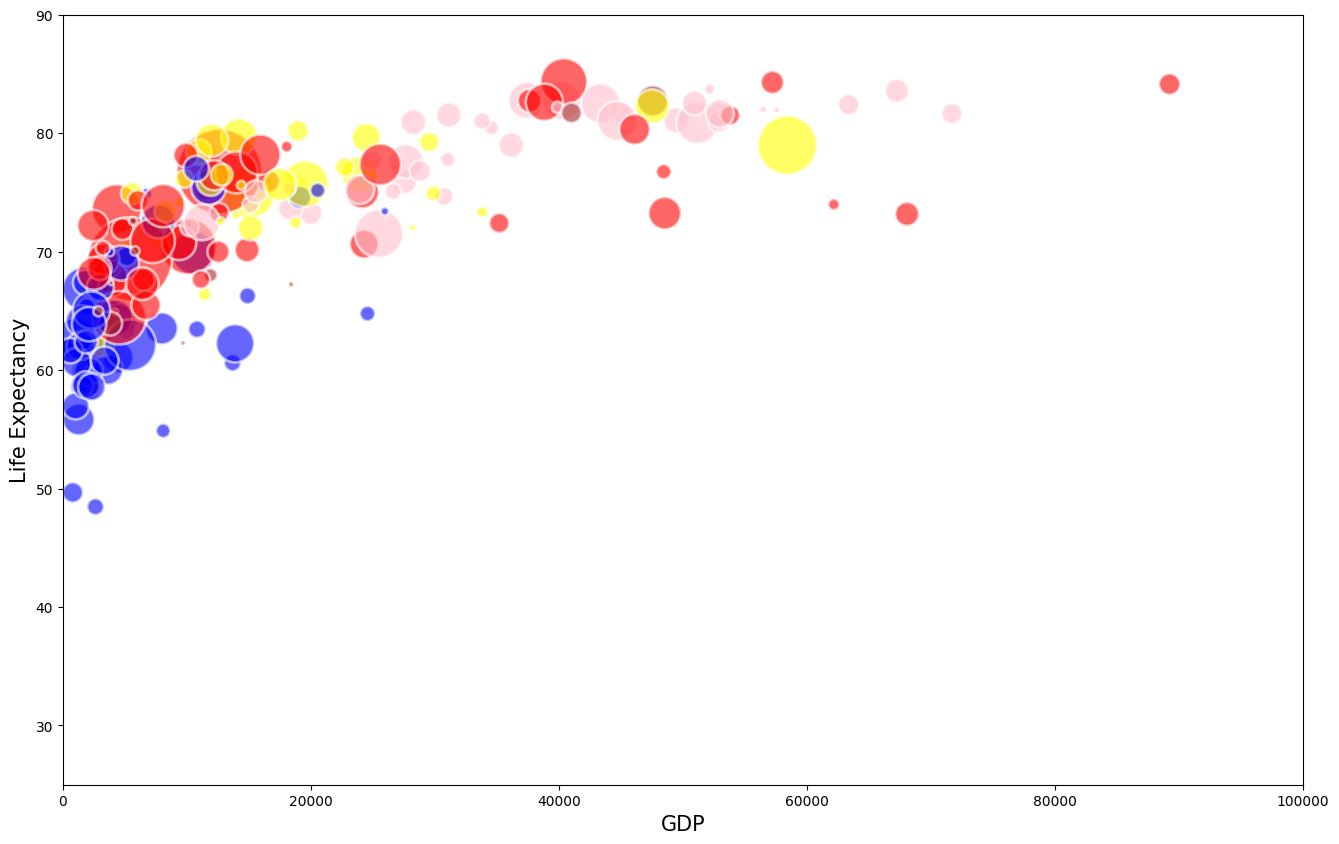

In [34]:
df = rename(df)
result = filter_year(df, 2015)
scatter_plot(result)

In [7]:
result.sort_values('gdp', ascending=False)

,country_short,year,life_expectancy,gdp,population,region,country_short
31822,mco,2015,79.55,197056.17110,36757,Europe,Monaco
31069,lux,2015,82.34,113182.72860,569536,Europe,Luxembourg
42810,qat,2015,75.46,101971.98960,2427331,Asia,Qatar
44917,sgp,2015,84.14,89248.12518,5525340,Asia,Singapore
23694,irl,2015,81.65,71692.56820,4702487,Europe,Ireland
...,...,...,...,...,...,...,...
10600,cod,2015,62.65,1032.57186,81035531,Africa,DR Congo
46272,som,2015,56.97,1029.69922,13806963,Africa,Somalia
8493,caf,2015,49.67,795.03702,4629320,Africa,Central African Republic
3376,bdi,2015,61.75,781.57929,11047580,Africa,Burundi


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation 
from IPython.display import HTML


# Set up the figure and axis, but don't plot anything initially
fig, ax = plt.subplots(figsize=(20, 10))
plt.close(fig)  # Prevent the static plot from displaying in Jupyter

def adapt_populations(s):
    return (s / 100000).map(lambda x: max(x, 10))
    #return s.map(lambda x: max(x, 5000000))

def animate(year):
    ax.clear()  # Clear previous frame
    filtered = filter_year(df, year).sort_values('population', ascending=True)
    sizes = np.sqrt(adapt_populations(filtered.population)) * 30
    colors = filtered['region'].map(continent_colors)
    
    # Scatter plot with data for the given year
    ax.scatter(filtered.gdp, filtered.life_expectancy, 
               s=sizes, 
               c=colors, 
               alpha=0.6, 
               edgecolors="w", 
               linewidth=2)
    
    # Set labels and limits
    ax.set_xlim(200, 100000)
    ax.set_ylim(15, 80)
    ax.set_xscale('log')
    # styling
    
    ax.text(0.95, 0.05, f'{year}', transform=ax.transAxes,
        fontsize=60, color='gray', ha='right', va='bottom')
    
    yticks = [25, 50, 75]
    ax.set_yticks(yticks)
    ax.set_yticklabels([f'{y}\nyears' for y in yticks], fontsize=20, ha='center', color='gray')
    ax.yaxis.set_tick_params(pad=30)

    xticks = [400, 4000, 40000]
    ax.set_xticks(xticks)
    ax.set_xticklabels([f'${x}' for x in xticks], fontsize=20, ha='center', color='gray')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.spines['bottom'].set_color('gray')
    ax.spines['left'].set_color('gray')

# Create the animation, but don't call plt.show() which can cause the initial static plot
animation = FuncAnimation(fig, animate, frames=range(df.year.min(), 2024))

# Display the animation in Jupyter Lab
HTML(animation.to_jshtml())
